# Import Libraries

In [252]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Covid 19 Risk Prediction/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Covid 19 Risk Prediction


In [253]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [254]:
covid_df = pd.read_csv("Covid Data.csv", low_memory = False)
print(covid_df.shape)

(1048575, 21)


# Preprocessing

**Lọc bỏ các giá trị sai với mô tả trong Kaggle**

In [255]:
covid_df = covid_df[(covid_df.PNEUMONIA == 1) | (covid_df.PNEUMONIA == 2)]
covid_df = covid_df[(covid_df.DIABETES == 1) | (covid_df.DIABETES == 2)]
covid_df = covid_df[(covid_df.COPD == 1) | (covid_df.COPD == 2)]
covid_df = covid_df[(covid_df.ASTHMA == 1) | (covid_df.ASTHMA == 2)]
covid_df = covid_df[(covid_df.INMSUPR == 1) | (covid_df.INMSUPR == 2)]
covid_df = covid_df[(covid_df.HIPERTENSION == 1) | (covid_df.HIPERTENSION == 2)]
covid_df = covid_df[(covid_df.OTHER_DISEASE == 1) | (covid_df.OTHER_DISEASE == 2)]
covid_df = covid_df[(covid_df.CARDIOVASCULAR == 1) | (covid_df.CARDIOVASCULAR == 2)]
covid_df = covid_df[(covid_df.OBESITY == 1) | (covid_df.OBESITY == 2)]
covid_df = covid_df[(covid_df.RENAL_CHRONIC == 1) | (covid_df.RENAL_CHRONIC == 2)]
covid_df = covid_df[(covid_df.TOBACCO == 1) | (covid_df.TOBACCO == 2)]
print(covid_df.shape)

(1025152, 21)


**Thống kê số lượng giá trị Null trong dataset (giá trị từ 97->99 là null, trừ trong age)**

In [256]:
def count_null(df):
  for col in df.columns:
    new_df = df.loc[(df[col]==97) | (df[col]==98) | (df[col]==99)]
    print("{}: {}".format(col, new_df.count()[0]))
count_null(covid_df)

USMER: 0
MEDICAL_UNIT: 0
SEX: 0
PATIENT_TYPE: 0
DATE_DIED: 0
INTUBED: 835406
PNEUMONIA: 0
AGE: 323
PREGNANT: 515111
DIABETES: 0
COPD: 0
ASTHMA: 0
INMSUPR: 0
HIPERTENSION: 0
OTHER_DISEASE: 0
CARDIOVASCULAR: 0
OBESITY: 0
RENAL_CHRONIC: 0
TOBACCO: 0
CLASIFFICATION_FINAL: 0
ICU: 835564


**Xử lí giá trị null trong PREGNANCIES**

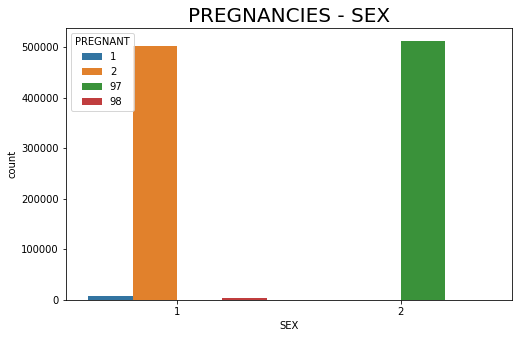

In [257]:
plt.figure(figsize = (8,5))
ax = sns.countplot(data=covid_df, x='SEX', hue='PREGNANT')
plt.title("PREGNANCIES - SEX", fontsize = 20);

- Giá trị Null 97 đều nằm ở Nam nên không thể có thai => đặt lại giá trị 97 là 2(không có thai). 
- Null 98 đều ở Nữ, không thể xác định => lọc bỏ.

In [258]:
covid_df.PREGNANT = covid_df.PREGNANT.replace(97, 2)
covid_df = covid_df[covid_df.PREGNANT != 98]
print(covid_df.shape)

(1021977, 21)


**Relabel cho các đặc trưng boolean**

In [259]:
covid_df.USMER = covid_df.USMER.apply(lambda x: x if x == 1 else 0)  
#covid_df.MEDICAL_UNIT                   # no = 0, yes = 1
covid_df.SEX = covid_df.SEX.apply(lambda x: x if x == 1 else 0)  
covid_df.PATIENT_TYPE = covid_df.PATIENT_TYPE.apply(lambda x: 0 if x == 1 else 1)     
covid_df.DATE_DIED = covid_df.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1)
covid_df.PNEUMONIA = covid_df.PNEUMONIA.apply(lambda x: x if x == 1 else 0)
#covid_df.AGE  
covid_df.PREGNANT = covid_df.PREGNANT.apply(lambda x: x if x == 1 else 0)           
covid_df.DIABETES = covid_df.DIABETES.apply(lambda x: x if x == 1 else 0)             
covid_df.COPD = covid_df.COPD.apply(lambda x: x if x == 1 else 0)                     
covid_df.ASTHMA = covid_df.ASTHMA.apply(lambda x: x if x == 1 else 0)                 
covid_df.INMSUPR = covid_df.INMSUPR.apply(lambda x: x if x == 1 else 0)               
covid_df.HIPERTENSION = covid_df.HIPERTENSION.apply(lambda x: x if x == 1 else 0)     
covid_df.OTHER_DISEASE = covid_df.OTHER_DISEASE.apply(lambda x: x if x == 1 else 0)  
covid_df.CARDIOVASCULAR = covid_df.CARDIOVASCULAR.apply(lambda x: x if x == 1 else 0) 
covid_df.OBESITY = covid_df.OBESITY.apply(lambda x: x if x == 1 else 0)               
covid_df.RENAL_CHRONIC = covid_df.RENAL_CHRONIC.apply(lambda x: x if x == 1 else 0)   
covid_df.TOBACCO = covid_df.TOBACCO.apply(lambda x: x if x == 1 else 0)    
#covid_df.CLASIFFICATION_FINAL 
print(covid_df.shape)        

(1021977, 21)


**Sử dụng mô hình Decision Tree để điền vào các giá trị null trong ICU**

In [260]:
icu_train = covid_df[(covid_df.ICU == 1) | (covid_df.ICU == 2)]
icu_miss = covid_df[(covid_df.ICU != 1) & (covid_df.ICU != 2)]

icu_x = icu_train[['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL']]
icu_y = icu_train['ICU']

icu_x = icu_x.to_numpy()
icu_y = icu_y.to_numpy()
icu_x_train, icu_x_test, icu_y_train, icu_y_test = train_test_split(icu_x, icu_y, train_size=0.8, random_state=1907)

model = DecisionTreeClassifier(max_depth=20).fit(icu_x_train, icu_y_train)
accuracy = accuracy_score(icu_y_test, model.predict(icu_x_test))
pre = precision_score(icu_y_test, model.predict(icu_x_test))
print("accuracy:", accuracy)
print("precision score:", pre) 

icu_miss_x = icu_miss[['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL']]
icu_miss['ICU'] = model.predict(icu_miss_x);

covid_df = pd.concat([icu_train, icu_miss])
covid_df.ICU = covid_df.ICU.apply(lambda x: x if x == 1 else 0) 
print(covid_df.shape)

accuracy: 0.8908524183110125
precision score: 0.24957841483979765


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
<ipython-input-260-a1d10244fe1c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_miss['ICU'] = model.predict(icu_miss_x);


(1021977, 21)


**Sử dụng mô hình Decision Tree để điền vào các giá trị null trong INTUBED**

In [261]:
int_train = covid_df[(covid_df.INTUBED == 1) | (covid_df.INTUBED == 2)]
int_miss = covid_df[(covid_df.INTUBED != 1) & (covid_df.INTUBED != 2)]

int_x = int_train[['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL']]
int_y = int_train['INTUBED']

int_x = int_x.to_numpy()
int_y = int_y.to_numpy()
int_x_train, int_x_test, int_y_train, int_y_test = train_test_split(int_x, int_y, train_size=0.8, random_state=1907)

model = DecisionTreeClassifier(max_depth=20).fit(int_x_train, int_y_train)
accuracy = accuracy_score(int_y_test, model.predict(int_x_test))
f1 = f1_score(int_y_test, model.predict(int_x_test))
print("accuracy:", accuracy)
print("f1 score:", f1) 

int_miss_x = int_miss[['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL']]
int_miss['INTUBED'] = model.predict(int_miss_x);

covid_df = pd.concat([int_train, int_miss])
covid_df.INTUBED = covid_df.INTUBED.apply(lambda x: x if x == 1 else 0) 
print(covid_df.shape)

accuracy: 0.8039220861486487
f1 score: 0.3633559002485217


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
<ipython-input-261-08d57f60d4d4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_miss['INTUBED'] = model.predict(int_miss_x);


(1021977, 21)


**Kiểm tra lại có còn dữ liệu null hay không**

In [262]:
count_null(covid_df)

USMER: 0
MEDICAL_UNIT: 0
SEX: 0
PATIENT_TYPE: 0
DATE_DIED: 0
INTUBED: 0
PNEUMONIA: 0
AGE: 322
PREGNANT: 0
DIABETES: 0
COPD: 0
ASTHMA: 0
INMSUPR: 0
HIPERTENSION: 0
OTHER_DISEASE: 0
CARDIOVASCULAR: 0
OBESITY: 0
RENAL_CHRONIC: 0
TOBACCO: 0
CLASIFFICATION_FINAL: 0
ICU: 0


**Tạo đặc trưng cần dự đoán - AT_RISK**

In [263]:
covid_df['AT_RISK'] = covid_df['DATE_DIED'] + covid_df['INTUBED'] + covid_df['ICU']
covid_df.AT_RISK = covid_df.AT_RISK.apply(lambda x: 1 if x > 0 else 0)   
print(covid_df.shape) 

(1021977, 22)


In [264]:
covid_df.drop(columns = ['INTUBED', 'ICU', 'DATE_DIED'], inplace=True)
print(covid_df.shape)

(1021977, 19)


**Tạo 3 bộ dữ liệu để thực nghiệm với random_state khác nhau**

In [265]:
covid_df.to_csv('Covid Data - New.csv', index = False)

In [266]:
train, test = train_test_split(covid_df, train_size=0.7, random_state=7, shuffle=True)
train.to_csv('lan1/train.csv', index = False)
test.to_csv('lan1/test.csv', index = False)

In [267]:
train, test = train_test_split(covid_df, train_size=0.7, random_state=14, shuffle=True)
train.to_csv('lan2/train.csv', index = False)
test.to_csv('lan2/test.csv', index = False)

In [268]:
train, test = train_test_split(covid_df, train_size=0.7, random_state=21, shuffle=True)
train.to_csv('lan3/train.csv', index = False)
test.to_csv('lan3/test.csv', index = False)